# Analysis of B cell receptor (BCR) data for 10X with pyVDJ

B cells only, outliers removed manually in notebook S1

This is a basic tutorial for pyVDJ v0.1.1. The package is available here: https://github.com/veghp/pyVDJ

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc 
import scipy
# for this you may need to do 'pip install pyvdj' and 'pip install upsetplot'
import pyvdj
import random

In [2]:
np.random.seed(0)

In [3]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/' # specifying output directory for figures
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [4]:
adata = sc.read('./adata_10X_B_cells_predicted_GC_phenotype.h5ad')
adata.shape

(5146, 3612)

In [5]:
adata

AnnData object with n_obs × n_vars = 5146 × 3612 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'probabilities_GC', 'GC_celltype_predictions'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', '

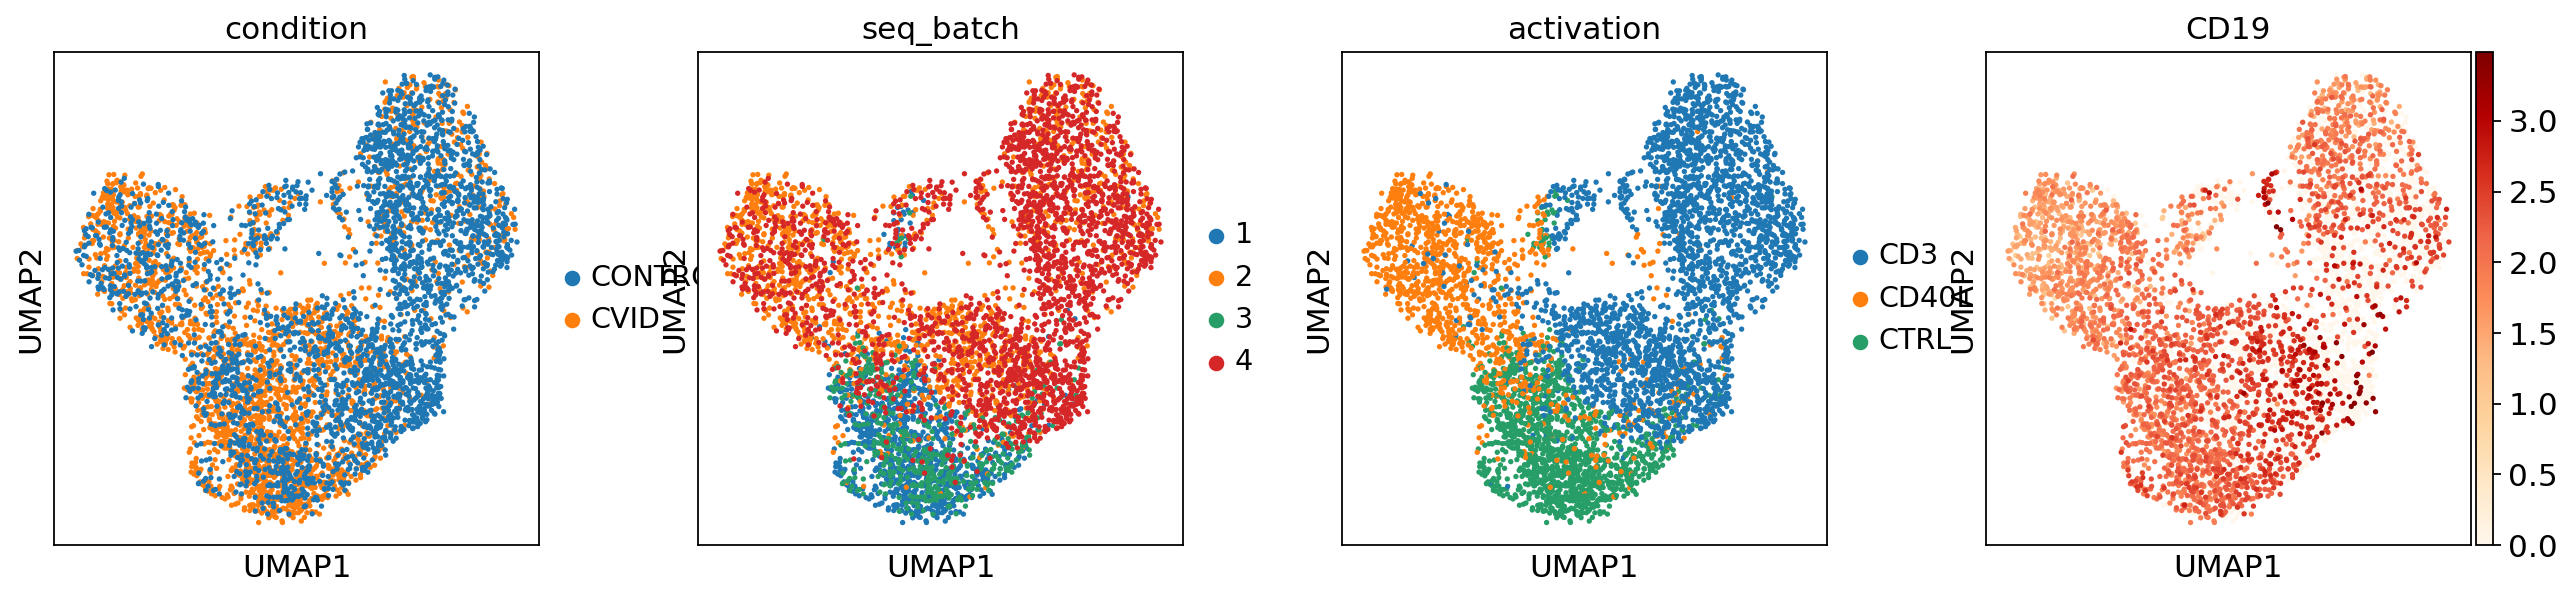

In [6]:
sc.pl.umap(adata, color=['condition', 'seq_batch','activation','CD19'], use_raw=True, cmap='OrRd')

## Load VDJ data

To load in the VDJ data, we construct filepaths and a dictionary linking files to sample names. The easiest way is to prepare a manifest that lists the GEX sample names next to the V(D)J 10x directory names in a csv file.

#### general scRNA-seq

Immunodeficiency8103070          CVID_CTRL_Bcells

Immunodeficiency8103072          CVID_CD40L_Bcells

Immunodeficiency8103073          CVID_CD3_Bcells

Immunodeficiency8103074          CONTROL_CTRL_Bcells

Immunodeficiency8103076          CONTROL_CD40L_Bcells

Immunodeficiency8103077          CONTROL_CD3_Bcells

#### BCR enriched

Immunodeficiency8103054          CVID_CTRL_Bcells_B

Immunodeficiency8103056          CVID_CD40L_Bcells_B

Immunodeficiency8103057          CVID_CD3_Bcells_B

Immunodeficiency8103058          CONTROL_CTRL_Bcells_B

Immunodeficiency8103060          CONTROL_CD40L_Bcells_B

Immunodeficiency8103061          CONTROL_CD3_Bcells_B

In [17]:
samples_enriched = ['Immunodeficiency8103054',
           'Immunodeficiency8103056','Immunodeficiency8103057',
           'Immunodeficiency8103058',
           'Immunodeficiency8103060','Immunodeficiency8103061']

In [8]:
dict_samples_enrich_to_general =  {}

# only B cells here

dict_samples_enrich_to_general['Immunodeficiency8103054'] = 'Immunodeficiency8103070'
dict_samples_enrich_to_general['Immunodeficiency8103056'] = 'Immunodeficiency8103072'
dict_samples_enrich_to_general['Immunodeficiency8103057'] = 'Immunodeficiency8103073'
dict_samples_enrich_to_general['Immunodeficiency8103058'] = 'Immunodeficiency8103074'
dict_samples_enrich_to_general['Immunodeficiency8103060'] = 'Immunodeficiency8103076'
dict_samples_enrich_to_general['Immunodeficiency8103061'] = 'Immunodeficiency8103077'

In [19]:
dict_path_to_sample = {}
    
for sample in list(samples_enriched[:8]):
    curr_path = './10X_BCR_data/' + sample + '/filtered_contig_annotations.csv'
    dict_path_to_sample[curr_path] = dict_samples_enrich_to_general[sample]


In [21]:
adata.obs.head()

activation batch   bh_pval condition     n_counts  n_genes  \
index                                                                           
AAAGATGGTAAACCTC-1       CTRL     0  0.911845      CVID  2134.637451     1176   
AAAGATGTCTGGCGAC-1       CTRL     0  0.911845      CVID  2631.008301     2300   
AAAGCAAAGCGGATCA-1       CTRL     0  0.955773      CVID  2247.625244     1312   
AAAGCAACAGTCGTGC-1       CTRL     0  0.955773      CVID  1358.176392      539   
AAAGCAAGTAGCCTAT-1       CTRL     0  0.955773      CVID  2131.114502     1219   

                    percent_mito                   sample  \
index                                                       
AAAGATGGTAAACCTC-1      0.088143  Immunodeficiency8103070   
AAAGATGTCTGGCGAC-1      0.062624  Immunodeficiency8103070   
AAAGCAAAGCGGATCA-1      0.092699  Immunodeficiency8103070   
AAAGCAACAGTCGTGC-1      0.129685  Immunodeficiency8103070   
AAAGCAAGTAGCCTAT-1      0.072920  Immunodeficiency8103070   

                    scrublet_cluster_score  scrublet_score  ... louvain_myel  \
index                                                       ...                
AAAGATGGTAAACCTC-1                0.114754        0.121019  ...            0   
AAAGATGTCTGGCGAC-1                0.127753        0.814433  ...            0   
AAAGCAAAGCGGATCA-1                0.089005        0.093525  ...            0   
AAAGCAACAGTCGTGC-1                0.089005        0.052632  ...            1   
AAAGCAAGTAGCCTAT-1                0.089005        0.121019  ...            0   

                    louvain_R_Tcells_7 louvain_R_Tcells_24568  \
index                                                           
AAAGATGGTAAACCTC-1                   0                      0   
AAAGATGTCTGGCGAC-1                   0                      0   
AAAGCAAAGCGGATCA-1                   0                      0   
AAAGCAACAGTCGTGC-1                   1                      1   
AAAGCAAGTAGCCTAT-1                   0                      0   

                   louvain_R_Tcells_24568_extra  \
index                                             
AAAGATGGTAAACCTC-1                            0   
AAAGATGTCTGGCGAC-1                            0   
AAAGCAAAGCGGATCA-1                            0   
AAAGCAACAGTCGTGC-1                            1   
AAAGCAAGTAGCCTAT-1                            0   

                   louvain_R_Tcells_24568_extra_extra  louvain_corrections  \
index                                                                        
AAAGATGGTAAACCTC-1                                  0                 none   
AAAGATGTCTGGCGAC-1                                  0                 none   
AAAGCAAAGCGGATCA-1                                  0                 none   
AAAGCAACAGTCGTGC-1                                  1                 none   
AAAGCAAGTAGCCTAT-1                                  0                 none   

                   louvain_corrections_2 has_Bcell_vdj_data probabilities_GC  \
index                                                                          
AAAGATGGTAAACCTC-1                  none               True         0.764508   
AAAGATGTCTGGCGAC-1                  none               True         0.764772   
AAAGCAAAGCGGATCA-1                  none               True         0.734959   
AAAGCAACAGTCGTGC-1                  none               True         0.985515   
AAAGCAAGTAGCCTAT-1                  none               True         0.867190   

                   GC_celltype_predictions  
index                                       
AAAGATGGTAAACCTC-1           Other_B_cells  
AAAGATGTCTGGCGAC-1           Other_B_cells  
AAAGCAAAGCGGATCA-1           Other_B_cells  
AAAGCAACAGTCGTGC-1           Other_B_cells  
AAAGCAAGTAGCCTAT-1           Other_B_cells  

[5 rows x 31 columns]

##### Prepare metadata column

The AnnData object must contain a metadata column (e.g. `adata.obs['vdj_obs']`) of the following format: `cellbarcode + '_' + samplename`. This can be constructed from the cell barcodes and sample names (provided that we have sample annotation):

In [22]:
adata.obs_names

Index(['AAAGATGGTAAACCTC-1', 'AAAGATGTCTGGCGAC-1', 'AAAGCAAAGCGGATCA-1',
       'AAAGCAACAGTCGTGC-1', 'AAAGCAAGTAGCCTAT-1', 'AAAGCAATCCGCGTTT-1',
       'AAAGTAGAGGCCGAAT-1', 'AAAGTAGAGTTTAGGA-1', 'AAAGTAGCACACATGT-1',
       'AAAGTAGCACGGTGTC-1',
       ...
       'TTTGGTTAGCTTCGCG-1', 'TTTGGTTCAGCTGTTA-1', 'TTTGGTTGTCCGAGTC-1',
       'TTTGGTTTCCGGGTGT-1', 'TTTGGTTTCGCGATCG-1', 'TTTGGTTTCTTCATGT-1',
       'TTTGTCAAGCCATCGC-1', 'TTTGTCAGTAAATGTG-1', 'TTTGTCAGTATCTGCA-1',
       'TTTGTCAGTCAATACC-1'],
      dtype='object', name='index', length=5146)

In [23]:
cellnames = adata.obs_names
cellbarcode = cellnames.str.split("-").str[:2].str.join("-") # cell barcode part + '-1'
adata.obs['vdj_obs'] = cellbarcode.astype(str) + "_" + adata.obs['sample'].astype(str)


We then read V(D)J data into the AnnData object and create annotations. Note that values in the `filtered_contig_annotations.csv` files cannot be directly added as annotations, because one cell may have 0 to n values per entry. It will be stored in `adata.uns` and annotation will be generated separately.

##### Load data

In [24]:
%%time
adata = pyvdj.load_vdj(dict_path_to_sample, adata, obs_col='vdj_obs', cellranger=3)

CPU times: user 11.4 s, sys: 236 ms, total: 11.6 s
Wall time: 11.7 s


This loaded 10x V(D)J sequencing data (i.e. filtered_contig_annotations.csv files) into adata.uns['pyvdj']. `obs_col` specifies the annotation column for cellnames, as prepared above. For Cell Ranger version 3, set the parameter to 3.
For definitions of some words (clone, clonotype etc) used in the next section, see https://github.com/veghp/pyVDJ.

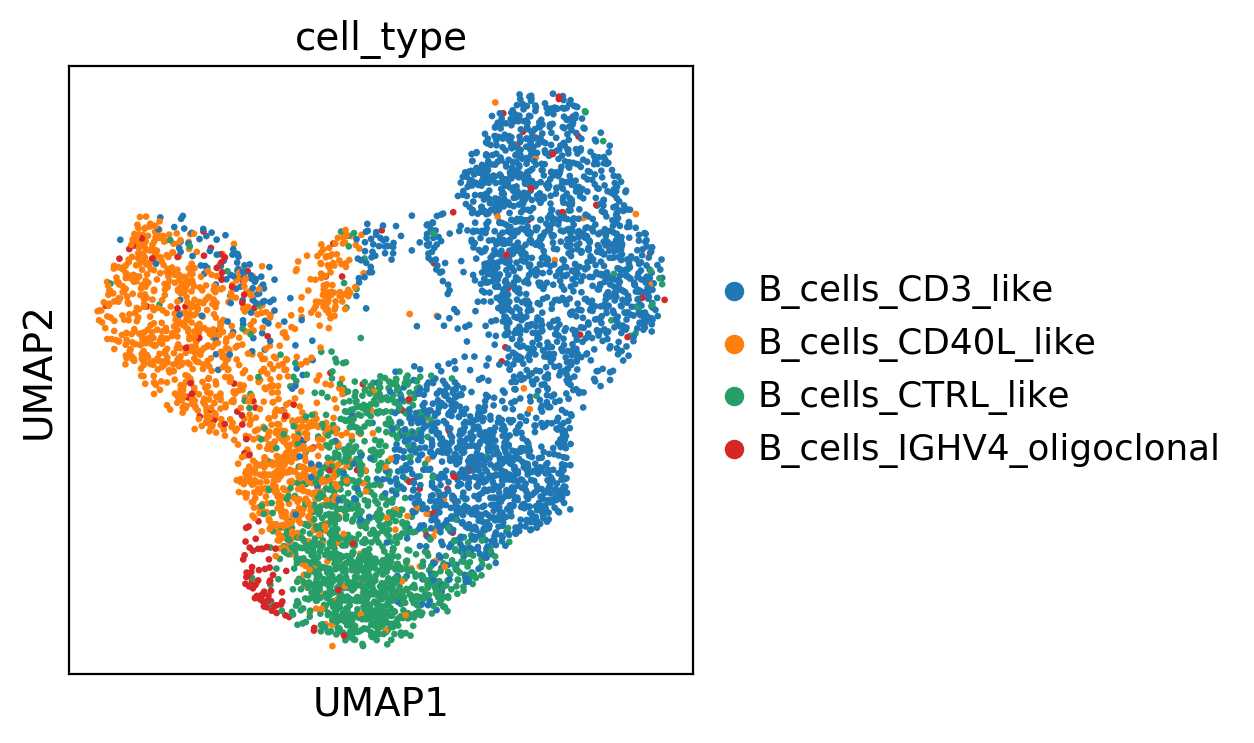

In [25]:
sc.pl.umap(adata, color=['cell_type'])

## VDJ annotation

In [26]:
adata = pyvdj.add_obs(adata, obs=['clonotype', 'is_clone', 'all_productive','any_productive'])

This generates annotation in `adata.obs`. Now we can plot V(D)J properties:

... storing 'vdj_all_productive' as categorical
... storing 'vdj_any_productive' as categorical


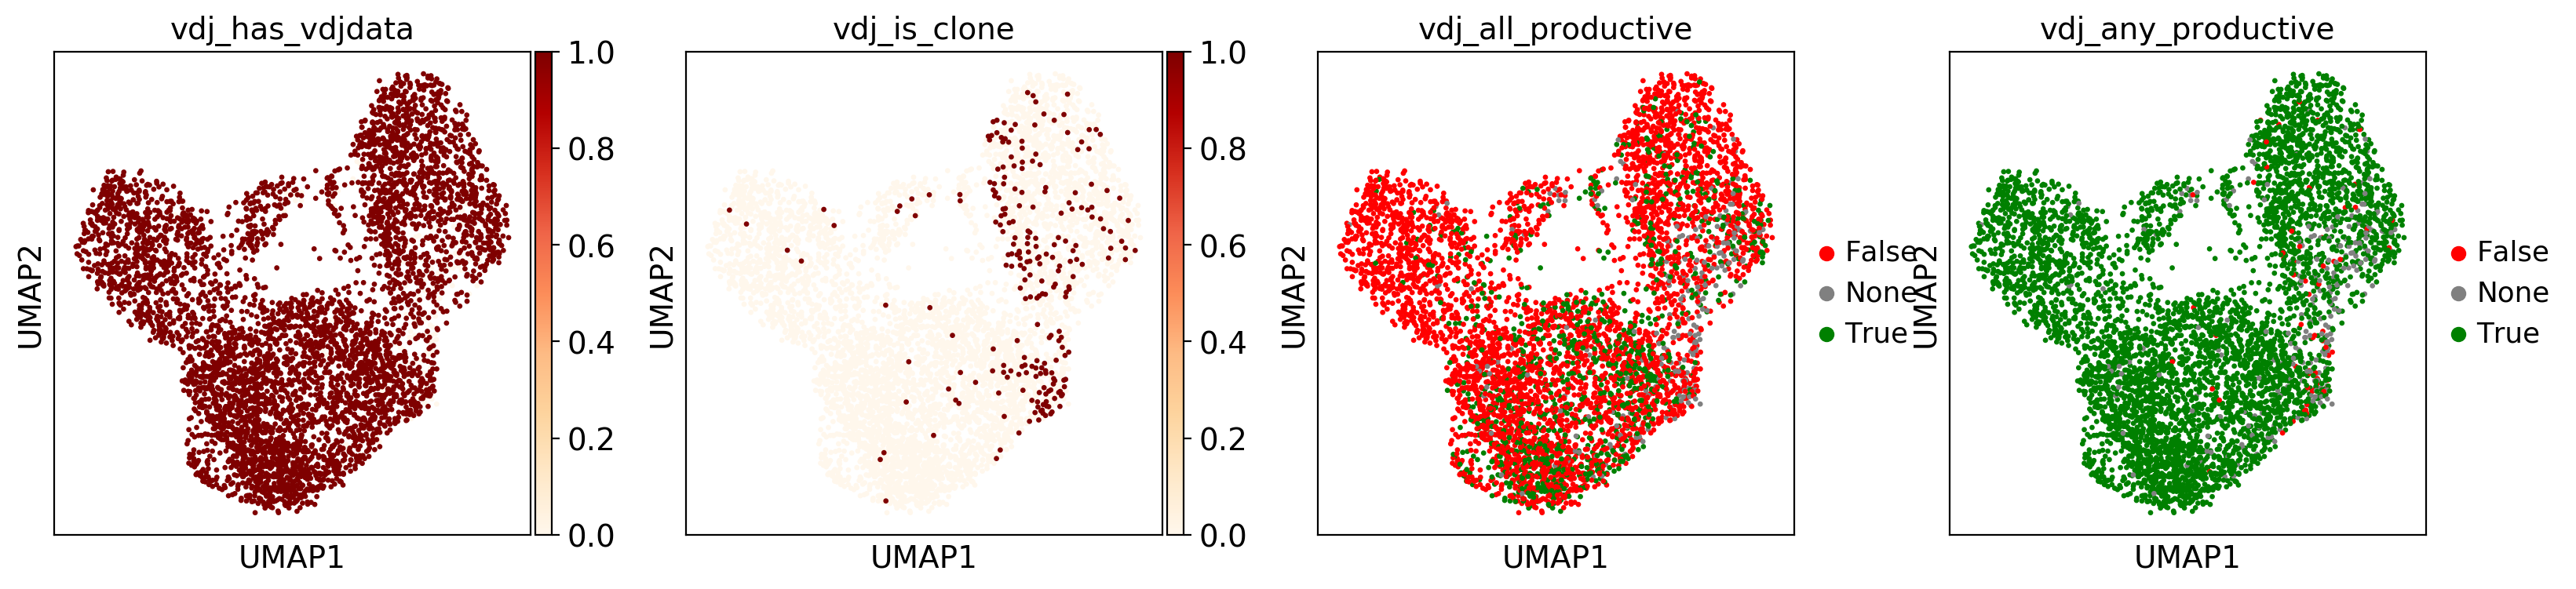

In [27]:
sc.pl.umap(adata, color=['vdj_has_vdjdata', 'vdj_is_clone', 'vdj_all_productive', 'vdj_any_productive'], cmap='OrRd', palette = ['red','grey','green'])

In [28]:
allcell = len(adata.obs['vdj_has_vdjdata'])
vdjcell = sum(adata.obs['vdj_has_vdjdata'])
print('We have %d cells with VDJ data, out of %d cells.' % (vdjcell, allcell))

We have 4909 cells with VDJ data, out of 5146 cells.


In [29]:
n_prod = sum(adata.obs['vdj_all_productive'] == 'True')
print('There are %d cells which have all productive chains.' % (n_prod))

There are 1043 cells which have all productive chains.


In [30]:
n_prod = sum(adata.obs['vdj_any_productive'] == 'True')
print('There are %d cells which have at least 1 productive chain.' % (n_prod))

There are 4846 cells which have at least 1 productive chain.


In [31]:
repl_values = {
    'True': 'False',
    'False': 'True',
    }
adata.obs['vdj_none_productive'] = adata.obs['vdj_any_productive'].replace(to_replace=repl_values, inplace=False)
n_prod = sum(adata.obs['vdj_none_productive'] == 'True')
print('There are %d cells with no productive chains.' % (n_prod))

There are 63 cells with no productive chains.


... storing 'vdj_none_productive' as categorical


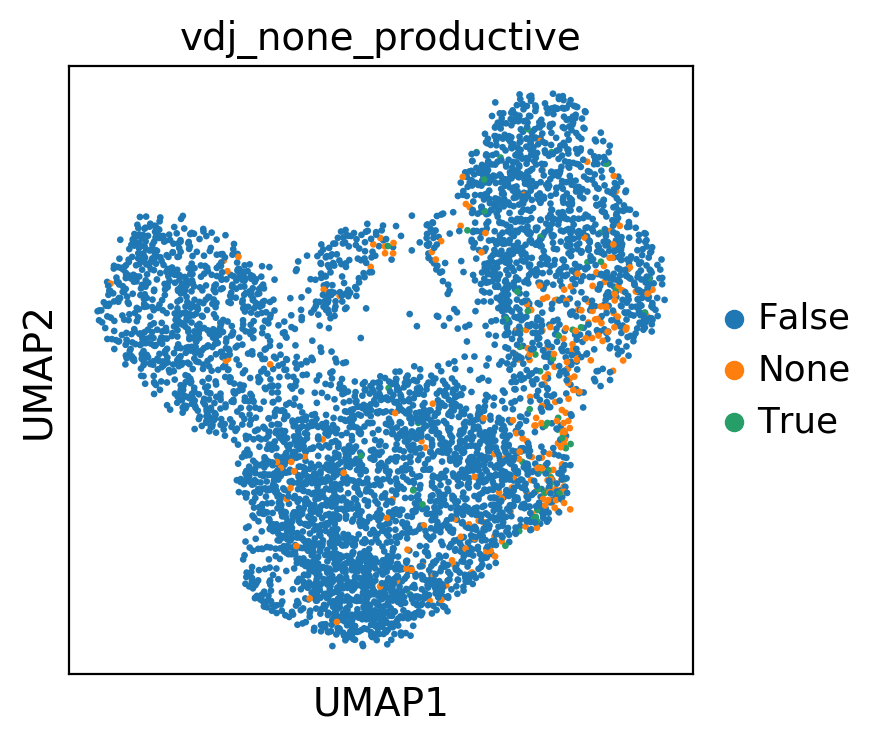

In [32]:
sc.pl.umap(adata, color=['vdj_none_productive'])


_________________________________________________________________________________________________________________________________________________________________________

Getting T:B doublet indices - for annotation of the main object

(Done, skip)

_________________________________________________________________________________________________________________________________________________________________________

The following command adds one metadata column for each type of chain found in the V(D)J data:

In [33]:
adata = pyvdj.add_obs(adata, obs=['chains'])

IGH
IGL
IGK
Multi
TRA
None
TRD
TRB
TRG


... storing 'vdj_chain_IGH' as categorical
... storing 'vdj_chain_IGL' as categorical
... storing 'vdj_chain_IGK' as categorical
... storing 'vdj_chain_Multi' as categorical
... storing 'vdj_chain_TRA' as categorical
... storing 'vdj_chain_None' as categorical
... storing 'vdj_chain_TRD' as categorical
... storing 'vdj_chain_TRB' as categorical
... storing 'vdj_chain_TRG' as categorical


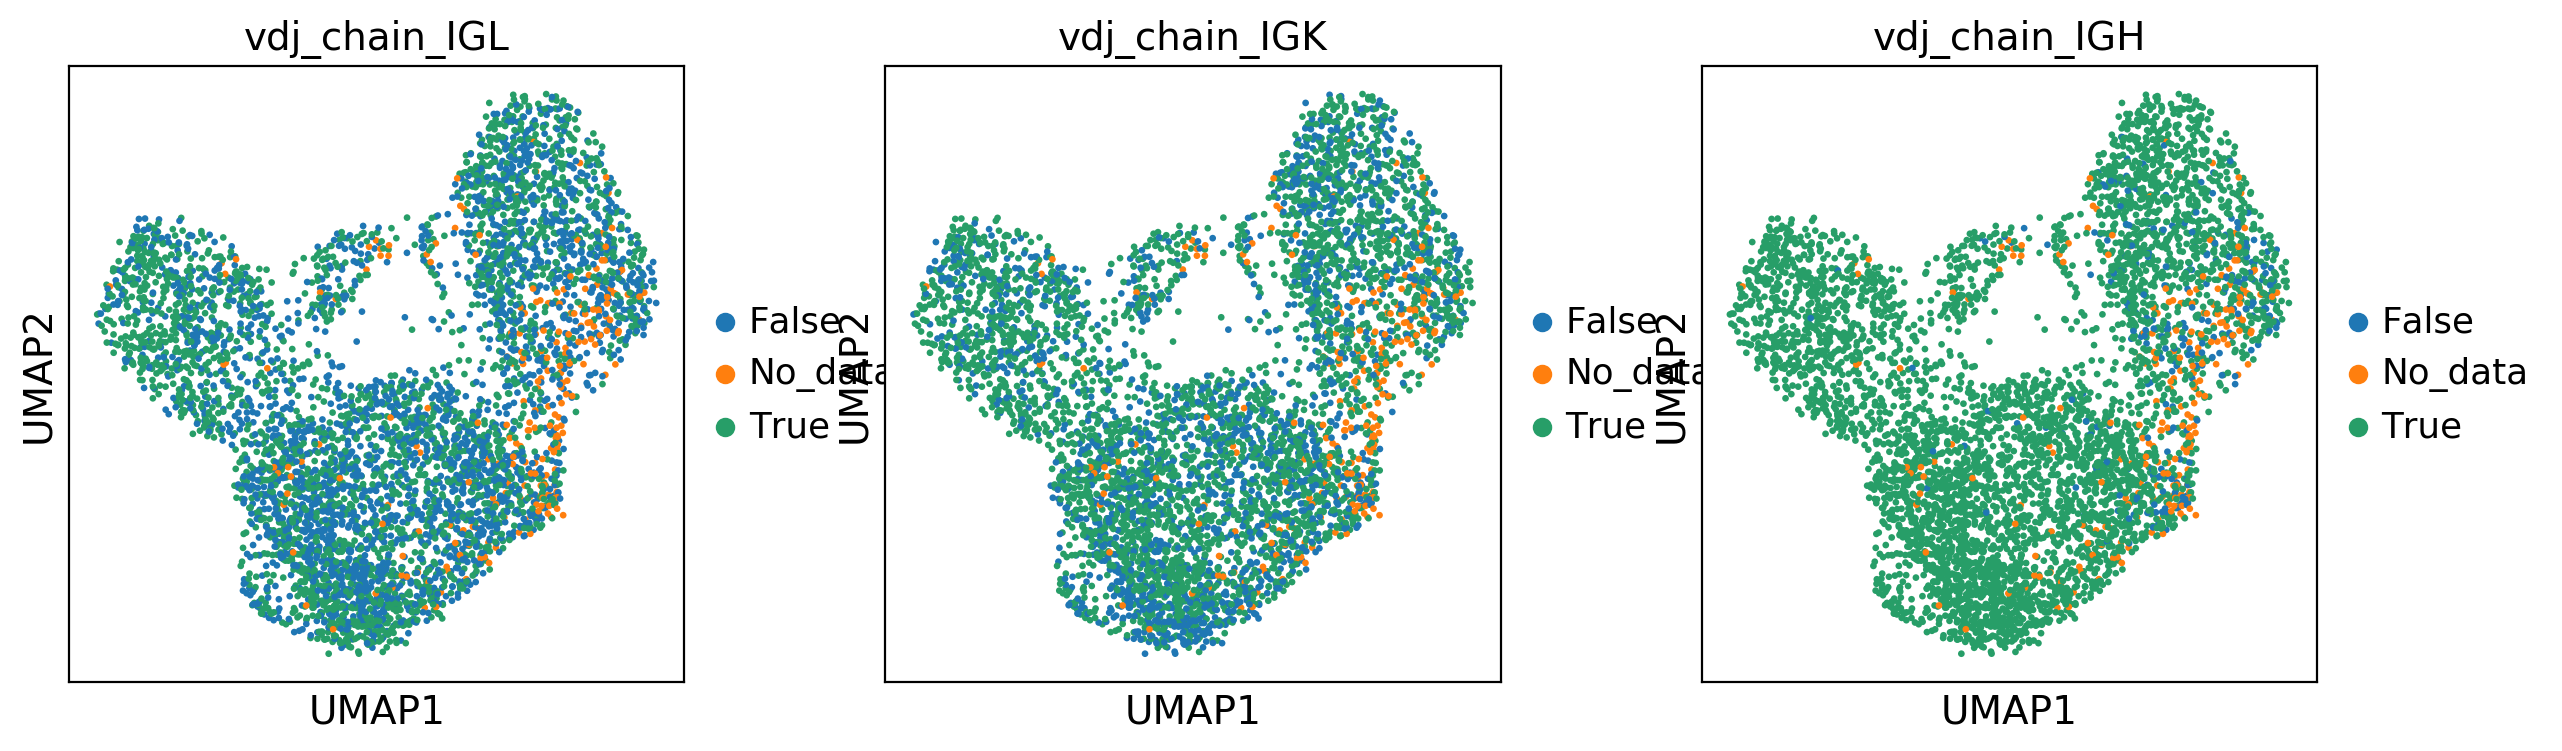

In [34]:
sc.pl.umap(adata, color=['vdj_chain_IGL', 'vdj_chain_IGK', 'vdj_chain_IGH'])

Most of the cells have alpha / beta chain. This was observed in other 10x datasets too (not shown).

In [35]:
%%time
adata = pyvdj.add_obs(adata, obs=['genes']) # one annotation for each gene

IGHM
IGLC3
IGHD
IGKC
None
IGHG3
IGLC1
IGLC2
IGHA1
IGHG2
IGHE
IGHA2
IGHG1
IGLC7
TRBC2
TRAC
TRGC1
TRGC2
IGHG4
TRBC1
TRDC
Preparing annotation for IGHM
Preparing annotation for IGLC3
Preparing annotation for IGHD
Preparing annotation for IGKC
Preparing annotation for None
Preparing annotation for IGHG3
Preparing annotation for IGLC1
Preparing annotation for IGLC2
Preparing annotation for IGHA1
Preparing annotation for IGHG2
Preparing annotation for IGHE
Preparing annotation for IGHA2
Preparing annotation for IGHG1
Preparing annotation for IGLC7
Preparing annotation for TRBC2
Preparing annotation for TRAC
Preparing annotation for TRGC1
Preparing annotation for TRGC2
Preparing annotation for IGHG4
Preparing annotation for TRBC1
Preparing annotation for TRDC
CPU times: user 33.1 s, sys: 0 ns, total: 33.1 s
Wall time: 33.2 s


... storing 'vdj_constant_IGHM' as categorical
... storing 'vdj_constant_IGLC3' as categorical
... storing 'vdj_constant_IGHD' as categorical
... storing 'vdj_constant_IGKC' as categorical
... storing 'vdj_constant_None' as categorical
... storing 'vdj_constant_IGHG3' as categorical
... storing 'vdj_constant_IGLC1' as categorical
... storing 'vdj_constant_IGLC2' as categorical
... storing 'vdj_constant_IGHA1' as categorical
... storing 'vdj_constant_IGHG2' as categorical
... storing 'vdj_constant_IGHE' as categorical
... storing 'vdj_constant_IGHA2' as categorical
... storing 'vdj_constant_IGHG1' as categorical
... storing 'vdj_constant_IGLC7' as categorical
... storing 'vdj_constant_TRBC2' as categorical
... storing 'vdj_constant_TRAC' as categorical
... storing 'vdj_constant_TRGC1' as categorical
... storing 'vdj_constant_TRGC2' as categorical
... storing 'vdj_constant_IGHG4' as categorical
... storing 'vdj_constant_TRBC1' as categorical
... storing 'vdj_constant_TRDC' as categorical

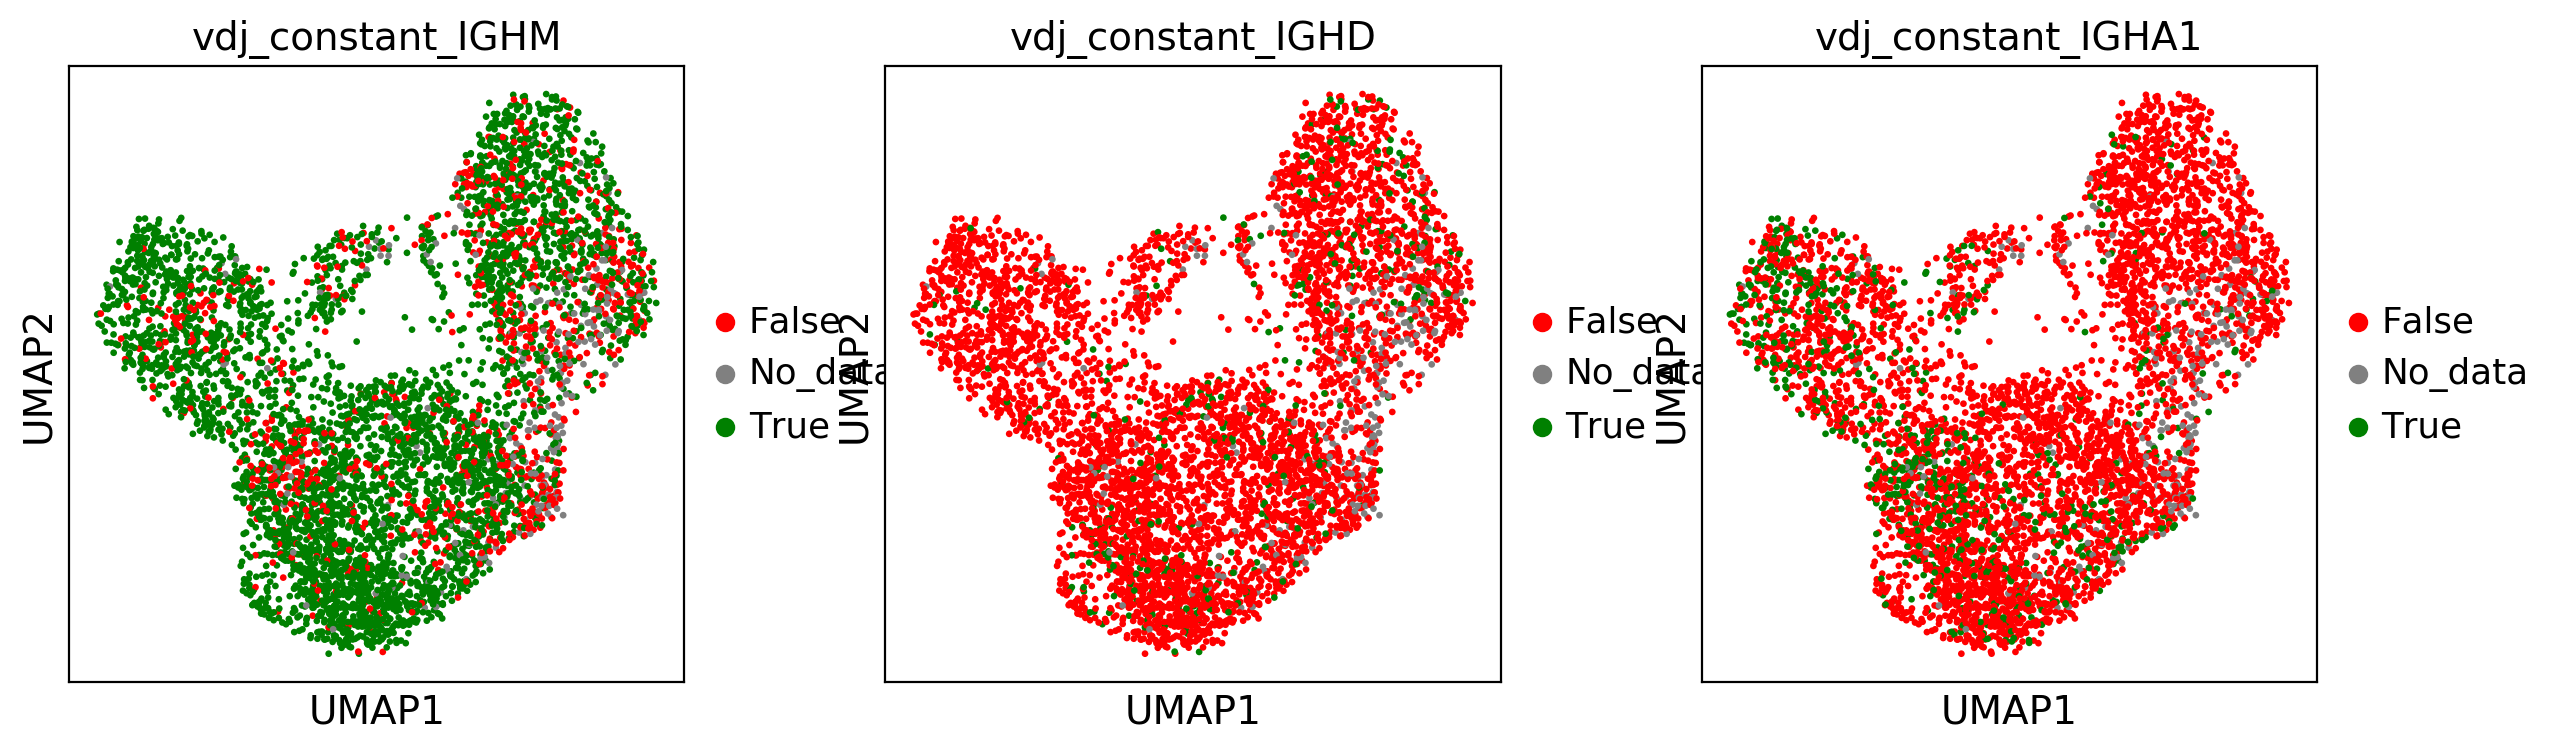

In [36]:
sc.pl.umap(adata, color=['vdj_constant_IGHM', 'vdj_constant_IGHD', 'vdj_constant_IGHA1'], palette=['red','grey','green'])

# compare this IG isotype distribution to the cytometry data (from Javi)

Similarly, we can add annotation for each V, each D and each J gene: 

In [37]:
%%time
# about 13 minutes
adata = pyvdj.add_obs(adata, obs=['v_genes', 'j_genes'])

IGHV4-61
IGLV2-14
IGHV5-51
IGKV2D-29
None
IGKV1D-39
IGHV4-59
IGKV3-15
IGHV3-30
IGHV3-33
IGHV4-34
IGKV2D-28
IGLV7-43
IGHV3-23
IGKV1-17
IGHV4-39
IGLV1-51
IGKV3-20
IGHV3-15
IGLV4-69
IGKV1-8
IGKV1-33
IGHV1-24
IGHV4-31
IGLV3-1
IGHV6-1
IGHV1-2
IGKV1-9
IGLV2-23
IGLV1-44
IGLV2-11
IGHV3-48
IGLV1-40
IGHV3-21
IGLV3-21
IGHV3-11
IGKV1D-37
IGHV1-46
IGKV2-30
IGHV3-49
IGHV1-69-2
IGKV4-1
IGHV3-53
IGKV3-11
IGHV3-43
IGHV3-7
IGLV3-10
IGLV3-16
IGKV2-24
IGHV7-81
IGKV1-5
IGHV1-18
IGLV3-25
IGLV3-19
IGHV3-66
IGLV8-61
IGHV2-70
IGKV1-27
IGKV1-12
IGHV2-5
IGLV9-49
IGHV3-64
IGHV3-73
IGLV6-57
IGHV1-3
IGLV1-36
IGKV6-21
IGLV3-9
IGKV5-2
IGHV3-74
IGHV3OR16-9
IGHV2-26
IGHV1-58
IGKV3D-11
IGHV3-72
IGLV7-46
IGKV1D-8
IGLV3-27
IGLV5-45
IGLV1-47
IGLV5-52
IGHV3-13
IGLV5-37
IGLV10-54
IGKV3-7
IGKV1-6
IGHV3-20
IGLV3-22
IGLV2-18
IGLV4-3
IGKV1-16
IGKV3D-20
IGLV2-8
IGKV2D-26
IGKV2D-24
IGHV4-4
IGKV6D-21
IGKV6D-41
IGKV3D-7
IGKV3OR2-268
IGKV1D-43
IGKV2D-30
IGKV1D-17
IGHV1-45
IGKV2D-40
IGLV3-12
IGKV1D-16
IGLV4-60
IGKV1D-13
IGHV4-28
IGHV1

## Clone counts

The clone count (of a clonotype) is defined as the number of clones in the clonotype (as determined by Cell Ranger). We can flag which cells are members of a clonotype with not fewer than n clones:


In [38]:
adata = pyvdj.add_gt_n(adata, n=10)

... storing 'vdj_v_IGHV4-61' as categorical
... storing 'vdj_v_IGLV2-14' as categorical
... storing 'vdj_v_IGHV5-51' as categorical
... storing 'vdj_v_IGKV2D-29' as categorical
... storing 'vdj_v_None' as categorical
... storing 'vdj_v_IGKV1D-39' as categorical
... storing 'vdj_v_IGHV4-59' as categorical
... storing 'vdj_v_IGKV3-15' as categorical
... storing 'vdj_v_IGHV3-30' as categorical
... storing 'vdj_v_IGHV3-33' as categorical
... storing 'vdj_v_IGHV4-34' as categorical
... storing 'vdj_v_IGKV2D-28' as categorical
... storing 'vdj_v_IGLV7-43' as categorical
... storing 'vdj_v_IGHV3-23' as categorical
... storing 'vdj_v_IGKV1-17' as categorical
... storing 'vdj_v_IGHV4-39' as categorical
... storing 'vdj_v_IGLV1-51' as categorical
... storing 'vdj_v_IGKV3-20' as categorical
... storing 'vdj_v_IGHV3-15' as categorical
... storing 'vdj_v_IGLV4-69' as categorical
... storing 'vdj_v_IGKV1-8' as categorical
... storing 'vdj_v_IGKV1-33' as categorical
... storing 'vdj_v_IGHV1-24' as ca

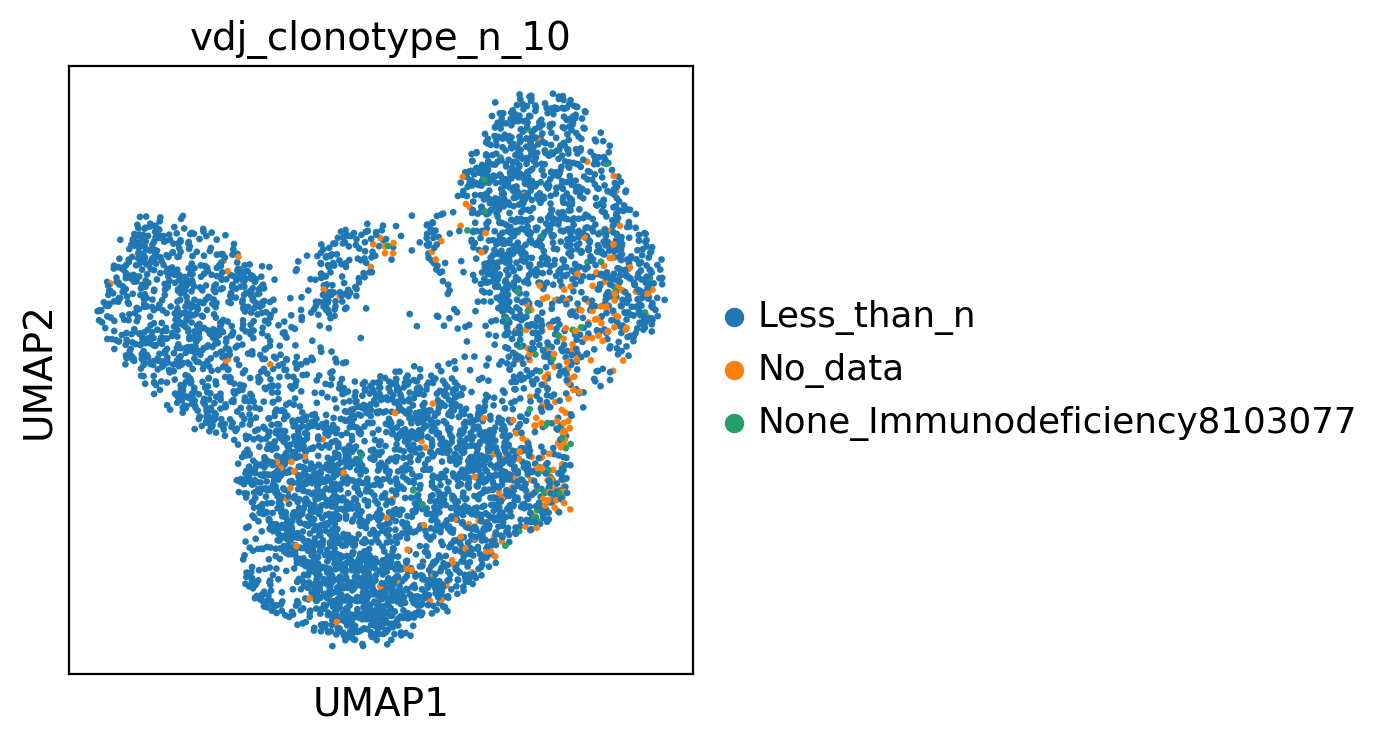

In [39]:
sc.pl.umap(adata, color='vdj_clonotype_n_10')

We can see that the most expanded clonotypes are in the CCL5 (granzyme, etc)-expressing group.

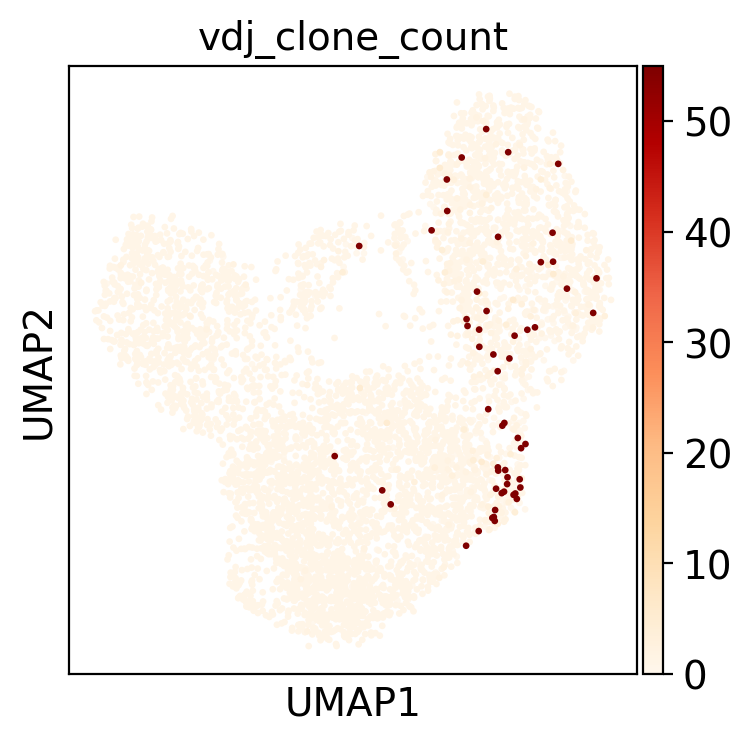

In [40]:
adata = pyvdj.add_obs(adata, obs=['clone_count'])
sc.pl.umap(adata, color='vdj_clone_count', cmap='OrRd')

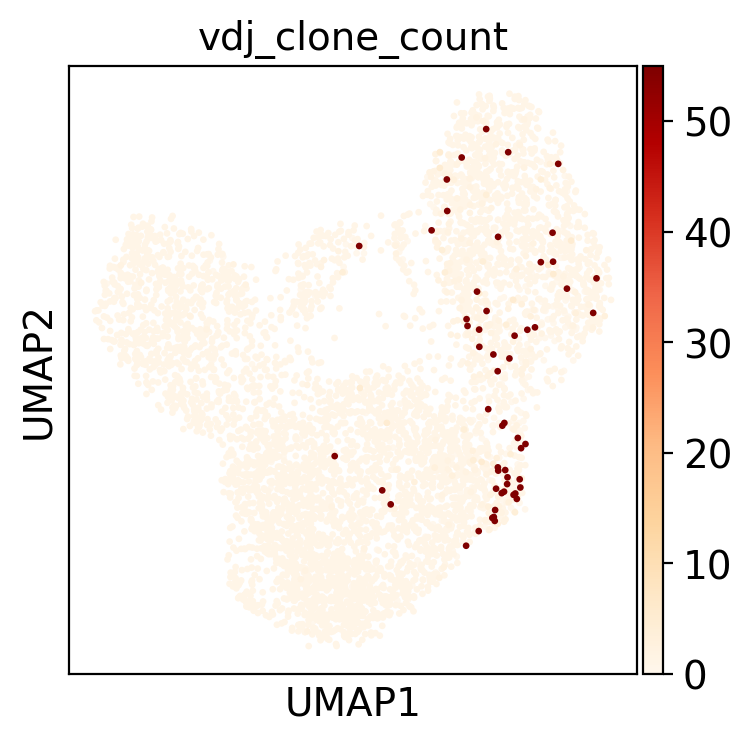

In [41]:
sc.pl.umap(adata, color='vdj_clone_count', cmap='OrRd')

In [42]:
adata

AnnData object with n_obs × n_vars = 5146 × 3612 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'probabilities_GC', 'GC_celltype_predictions', 'vdj_obs', 'vdj_has_vdjdata', 'vdj_clonotype', 'vdj_clone_count', 'vdj_is_clone', 'vdj_all_productive', 'vdj_any_productive', 'vdj_none_productive', 'vdj_chain_IGH', 'vdj_chain_IGL', 'vdj_chain_IGK', 'vdj_chain_Multi', 'vdj_chain_TRA', 'vdj_chain_None', 'vdj_chain_TRD', 'vdj_chain_TRB', 'vdj_chain_TRG', 'vdj_constant_IGHM', 'vdj_constant_IGLC3', 'vdj_constant_IGHD', 'vdj_constant_IGKC', 'vdj_c

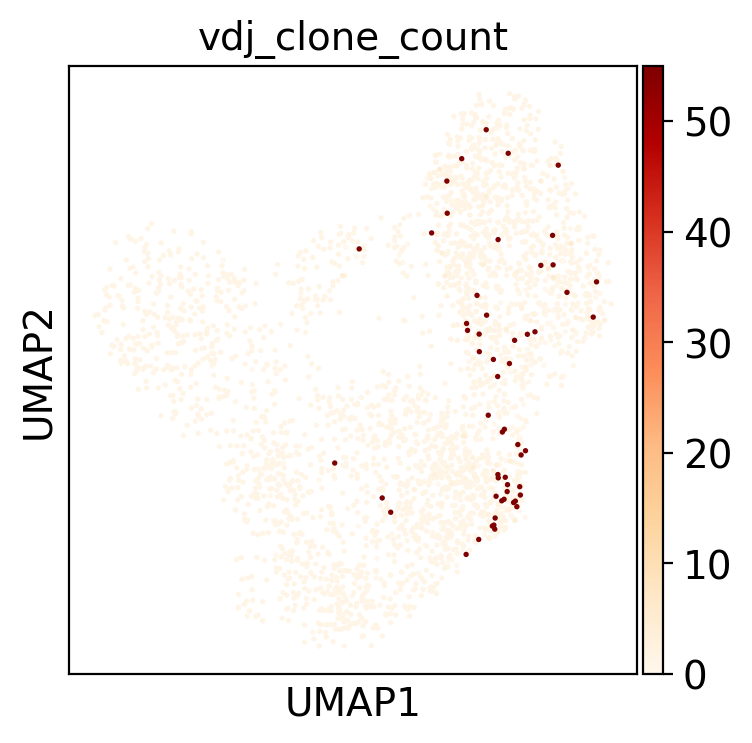

In [43]:
sc.pl.umap(adata[adata.obs['condition'] == 'CONTROL'], color='vdj_clone_count', cmap='OrRd', s=15, 
           save='_vdj_clone_count_ctrl_B_cells.pdf')


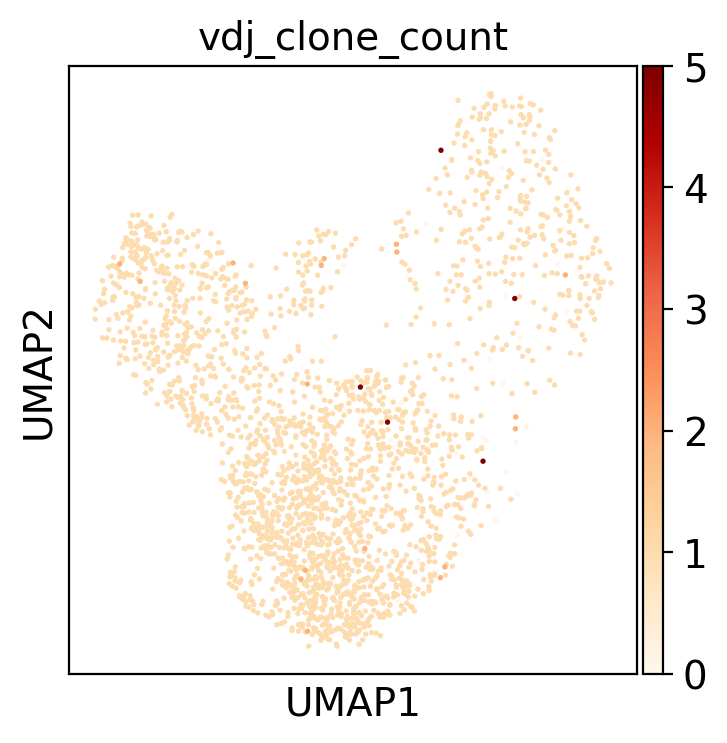

In [44]:
sc.pl.umap(adata[adata.obs['condition'] == 'CVID'], color='vdj_clone_count', cmap='OrRd', s=15,
          save='_vdj_clone_count_CVID_B_cells.pdf')

The plot shows the number of clones in each cell's clonotype, and provides an alternative view of expanded clonotypes. Let's retrieve the CDR3 amino acid sequences of the above clonotypes:

In [46]:
clonotypes = adata.obs['vdj_clonotype_n_10'].unique()[2:].tolist()
cdr3_dict = pyvdj.get_spec(adata, clonotypes)
cdr3_dict

None_Immunodeficiency8103077


{'None_Immunodeficiency8103077': ['CQQSYSTPRTF',
  'CSLPGAAGAVW',
  'CAAWDDSLTGRVF',
  'CMLSYSGSLVF',
  'CLQRLRGYTF',
  'CPLPGAAGAVW',
  'CQQYGDSPPCTF',
  'CARGGRGPDYGTRIDKW',
  'CQQYNNGPETF',
  'CQQSYSTSWTF',
  'CAKLEDDDFIGTRLNFDYW',
  'CMQGLQAITF',
  'CTQATQFPWTF',
  'CQQYSSFSTF']}

This can be used to find their specificity in CDR3 databases, such as [VDJdb](http://vdjdb.cdr3.net/).

## Clonotype distribution

Now we obtain statistics for each specified AnnData metadata category:

In [47]:
meta = 'sample'
#~ adata.obs['metadata']  # one category for each 10x channel
adata = pyvdj.stats(adata, meta)

Adding CDR3 to adata.uns


If ran the first time, this will add a dictionary in `adata.uns['pyvdj']['cdr3']`, which stores a set of productive CDR3s for each cell:

In [48]:
adata.uns['pyvdj']['cdr3']['cdr3sets']
adata.uns['pyvdj']['cdr3']['cdr3_codes']  # and a dictionary of {code: cdr3 set}
adata.uns['pyvdj']['cdr3']['cdr3_codes_rev']  # and the reverse dictionary of {cdr3set: code}

{frozenset({'CARDRDGRQDYW', 'CQQSYSTLTWTF'}): 0,
 frozenset({'CAKGGSNFDWLLEISYYYYMDVW', 'CQSYDSSLSGPGVF'}): 1,
 frozenset({'CASSGDSPEDYW', 'CQSADSSGTSYVF'}): 2,
 frozenset({'CARVTSSGRPAFDIW', 'CQVWDSSSDHVVF'}): 3,
 frozenset({'CAVSGYSYGSDSDYW', 'CLQHNTRGTF'}): 4,
 frozenset({'CAHIPNRVDDFWSGTDFDYW', 'CQSYDSSLSGYVVF'}): 5,
 frozenset({'CARGGGYCSSTSCYSGYYYGMDVW', 'CQSADSSGTYYVF'}): 6,
 frozenset({'CARQSVFDYW', 'CLQHNSYHLTF'}): 7,
 frozenset({'CAREPSSGYYPRGWFDPW', 'CQQYNSYPYTF'}): 8,
 frozenset({'CQQYGSSPRTF'}): 9,
 frozenset({'CASRHHW', 'CLQHNSYPPWTF', 'CMQGIHLPLYTF'}): 10,
 frozenset({'CAHTYYDILTGYYNVRECYFDYW', 'CQVWDSSSDHRVVF'}): 11,
 frozenset({'CAKDALQTYYYDSSGYPGAHPRFDYW', 'CQSYDSSLSGVVF'}): 12,
 frozenset({'CAKDSSWYSGGWFDPW', 'CQQYNNWPPWTF'}): 13,
 frozenset({'CARPNSPYYSFGFDIW', 'CMQALQSPWTF', 'CQQYNNWPPYTF'}): 14,
 frozenset({'CATYDILTGCYW', 'CVLYMGSGIVVF'}): 15,
 frozenset({'CARQVPKAARRESGATGWFDPW', 'CQQYNNWPRTF'}): 16,
 frozenset({'CQAWDSSTYVVF'}): 17,
 frozenset({'CAREVFGVEPPFYYY

This was used to calculate the statistics that was added as a dictionary (`adata.uns['pyvdj']['stats'][meta]`):

In [49]:
adata.uns['pyvdj']['stats'][meta].keys()

dict_keys(['meta', 'cells', 'clonotype_counts', 'clonotype_dist', 'cdr3'])

See the [readme](https://github.com/veghp/pyVDJ) for details on output.

In [50]:
# We define a plotting function. For easy customization, it is not included in the package.
def plot_cells(stats_dict):
    hasvdj = stats_dict['cells'][1]
    novdj = stats_dict['cells'][0] - hasvdj

    bars = np.add(hasvdj, novdj).tolist()
     
    x_axis = list(range(0, len(bars)))  # bar positions on x
    x_names = list(hasvdj.index)
    barWidth = 1

    p1 = plt.bar(x_axis, hasvdj, color='#553864', edgecolor='white', width=barWidth)
    p2 = plt.bar(x_axis, novdj, bottom=hasvdj, color='#81a75d', edgecolor='white', width=barWidth)
    plt.legend((p1[0], p2[0]), ('Has VDJ', 'No VDJ'), ncol=2, bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
    plt.grid(False)
    plt.xticks(x_axis, x_names, rotation='vertical')
    plt.subplots_adjust(bottom=0.4, left=0.2)
    plt.xlabel(stats_dict['meta'])
    plt.ylabel('Number of cells')


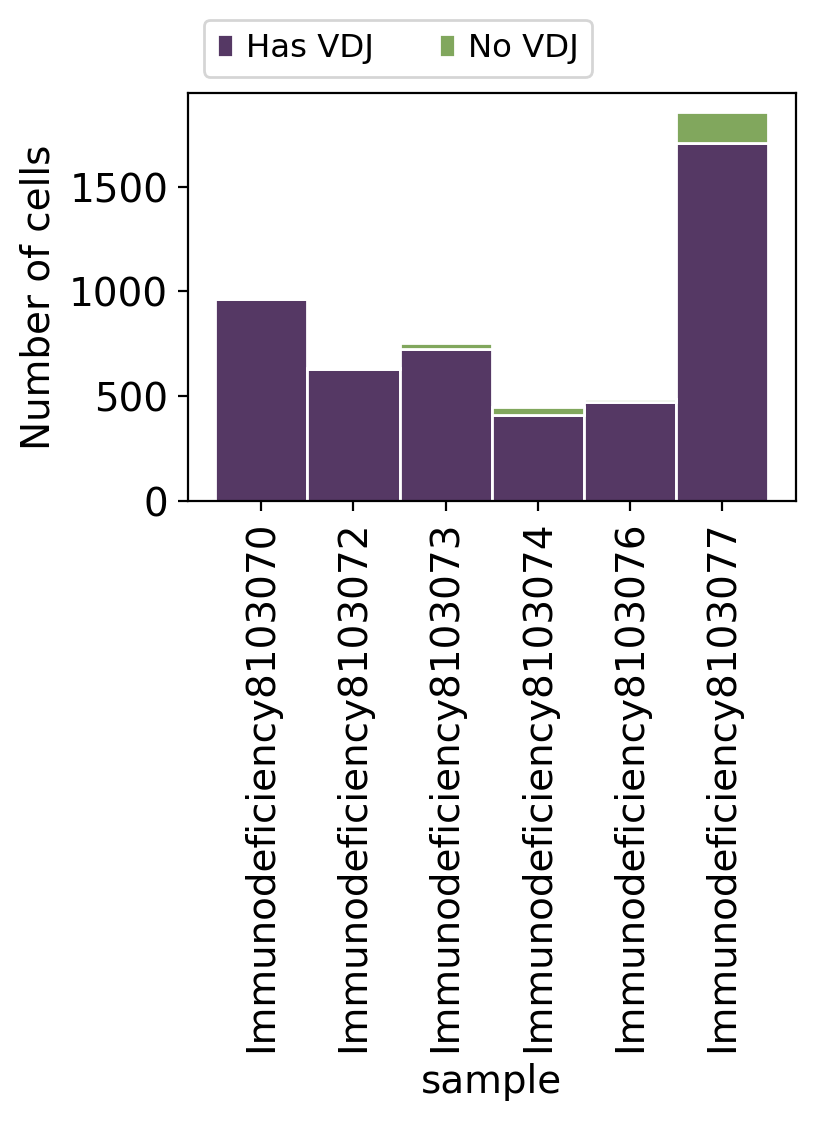

In [51]:
# Now we can plot cell numbers:
plot_cells(adata.uns['pyvdj']['stats'][meta])

Plot clonotype distribution for each sample:

In [57]:
adata.uns['pyvdj']['stats']['sample']['clonotype_dist']

sample                   vdj_clone_count
Immunodeficiency8103070  1                   956
                         2                     6
                         0                     5
Immunodeficiency8103072  1                   623
                         2                     6
                         0                     5
Immunodeficiency8103073  1                   714
                         0                    28
                         2                     6
                         5                     5
Immunodeficiency8103074  1                   409
                         0                    40
Immunodeficiency8103076  1                   471
                         0                    14
                         2                     2
Immunodeficiency8103077  1                  1502
                         0                   145
                         2                   122
                         55                   55
                         3  

In [72]:
df_clones = pd.DataFrame(adata.uns['pyvdj']['stats']['sample']['clonotype_dist'])
df_clones.index.names = ['sample', 'vdj_clone_expansion']

In [74]:
df_clones.to_csv('df_clones_BCR.csv')

Immunodeficiency8103070


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """


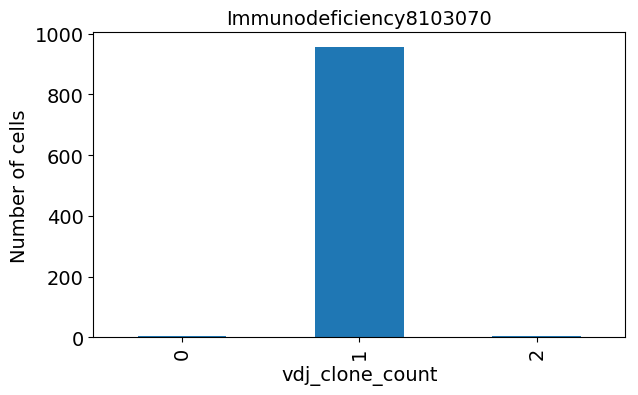

Immunodeficiency8103072


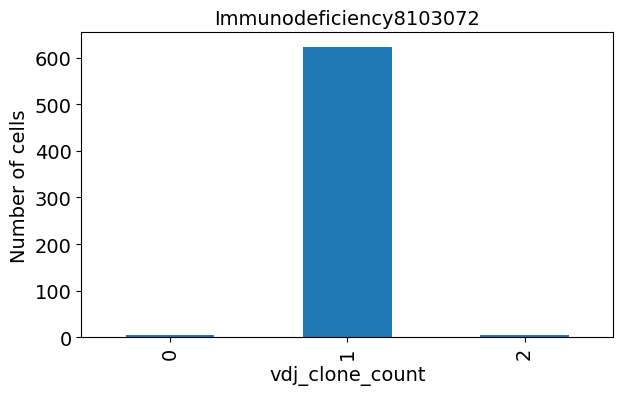

Immunodeficiency8103073


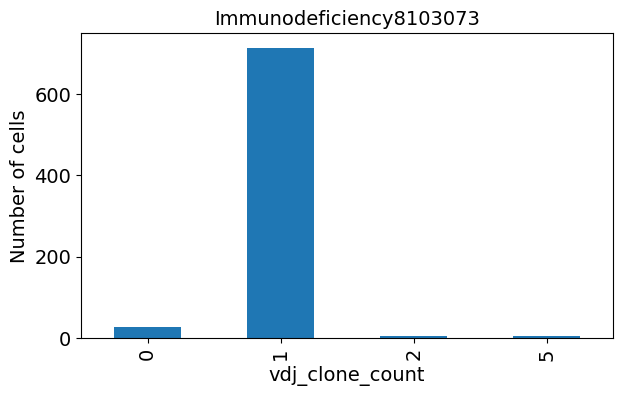

Immunodeficiency8103074


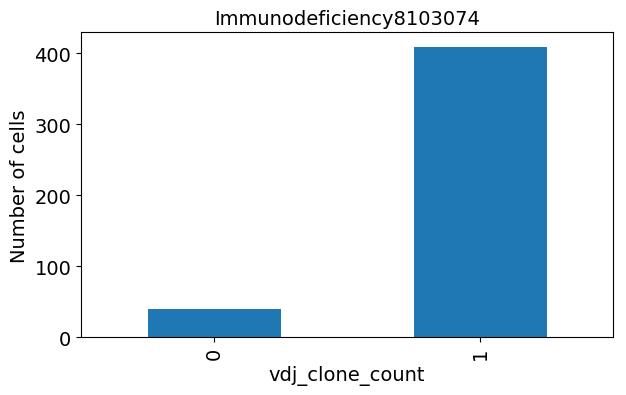

Immunodeficiency8103076


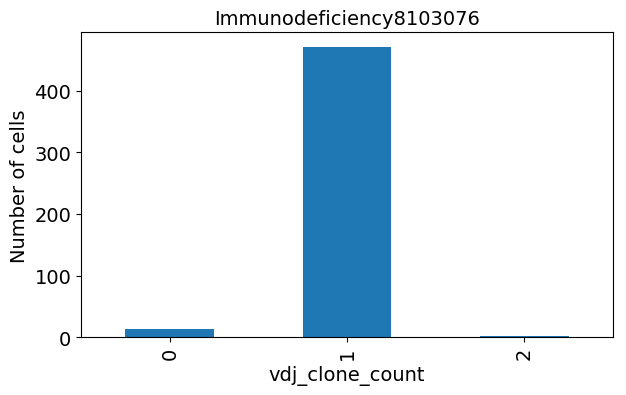

Immunodeficiency8103077


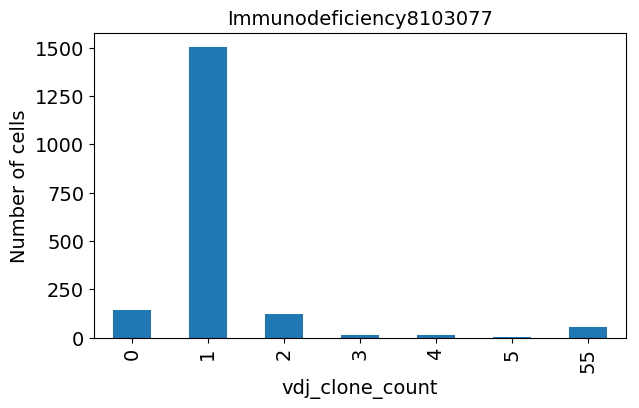

In [53]:
sc.settings.set_figure_params(dpi=50)
clonotype_dist = adata.uns['pyvdj']['stats'][meta]['clonotype_dist']
for meta_item in adata.obs[meta].unique().tolist():
    print(meta_item)
    clonotype_dist[meta_item].sort_index().plot('bar', figsize=(7, 5))
    plt.subplots_adjust(bottom=0.3, left=0.2)
    plt.grid(False)
    plt.title(meta_item)
    plt.ylabel('Number of cells')
    plt.show()


Here, vdj_clone_count = 0 means that the cell did not have VDJ data, and vdj_clone_count = 1 means that the clonotype has only 1 cell (clone).

Apparently, more clonotypes are in the control (normal) sample (C), than in GOF (P1). This could be due to either decreased diversity in GOF, or expansion of a few clonotypes in GOF, which makes it more likely to sample those cells.

In our data, P2 is a non-adult sample, and that could explain the lack of clonotype expansion.

We can plot in a slightly different way, with x-axis being a proper number line:

In [48]:
x_max = max(adata.obs['vdj_clone_count'])
x_max = int(x_max*1.05)

samples_plot = ['Immunodeficiency8103070', 'Immunodeficiency8103072', 'Immunodeficiency8103073',
                'Immunodeficiency8103074', 'Immunodeficiency8103076', 'Immunodeficiency8103077']

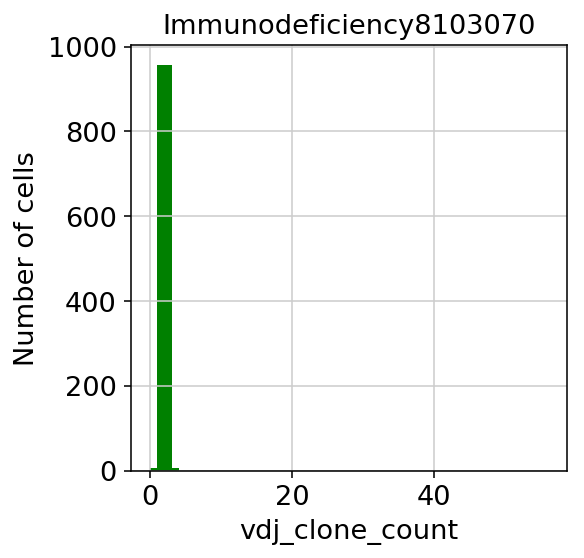

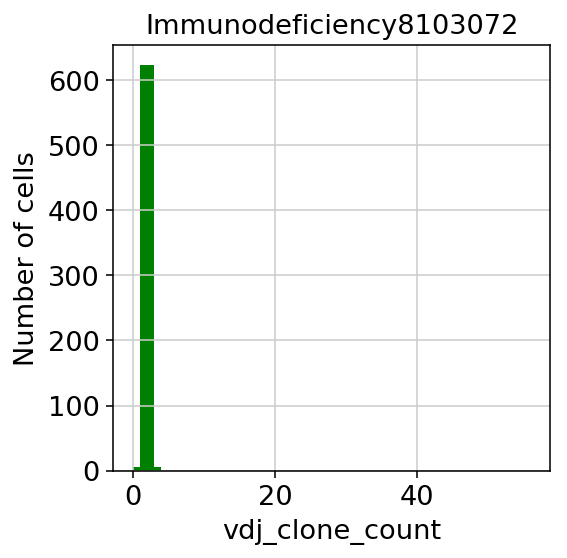

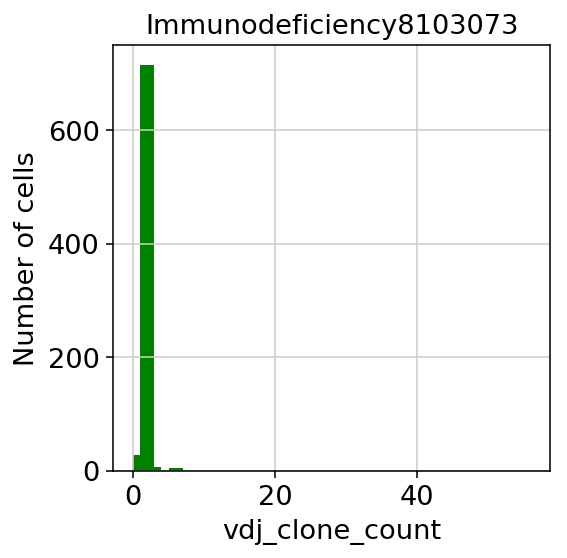

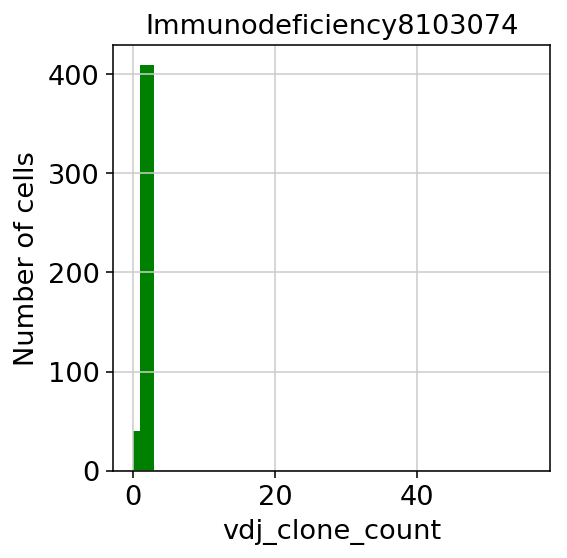

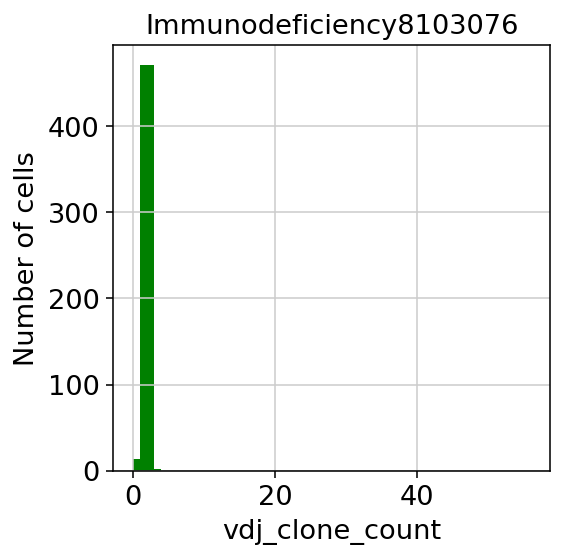

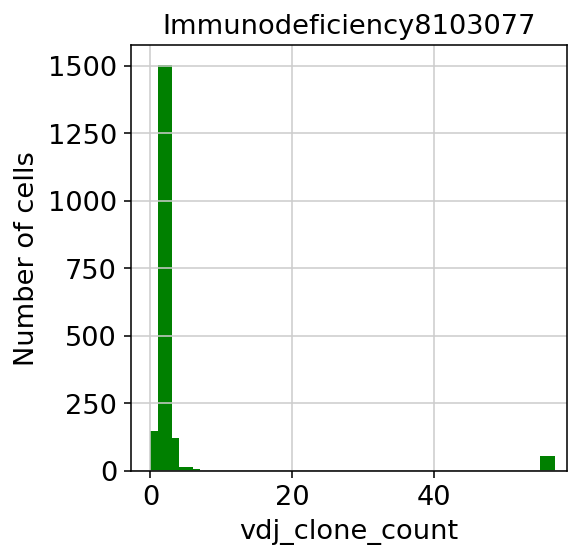

In [49]:
sc.settings.set_figure_params(dpi=70)
for s in samples_plot:
    df = adata.obs.loc[adata.obs[meta] == s]
    x1 = df['vdj_clone_count']
    plt.hist(x1, bins=range(0, int(x_max)), width = 2, color='g', label=s)
    plt.title(s)
    plt.xlabel('vdj_clone_count')
    plt.ylabel('Number of cells')
    plt.show()


The best approach is, however, to plot the histograms of the number of clonotypes vs clonotype size. First we save the counts for the R [powerTCR](https://github.com/hillarykoch/powerTCR) package. This can be used for finding a threshold for expanded clonotypes, calculating diversity indices, comparing samples. For details, see their [publication](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006571).

In [50]:
clonotype_valcounts = adata.obs.groupby(meta)['vdj_clonotype'].value_counts()
cl_valcount_index = list(clonotype_valcounts.index.get_level_values(0).unique())

In [51]:
for s in adata.obs[meta].unique().tolist():
    print(s)
    if s not in cl_valcount_index:
        print(s)
        continue
    clonotype_valcounts[s].to_csv('count_vectors/count_vector_' + s + '.csv', index=False)

Immunodeficiency8103070
Immunodeficiency8103072
Immunodeficiency8103073
Immunodeficiency8103074
Immunodeficiency8103076
Immunodeficiency8103077


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


An R script for calculating the threshold for each sample is provided [here](https://github.com/veghp/pyVDJ/blob/master/tutorials/thresholds.R). Then we can load the calculated thresholds:

In [52]:
threshold_df = pd.read_csv('threshold_df.csv', header=0)
thresh_dict = dict(zip(threshold_df.name, threshold_df.threshold))

FileNotFoundError: [Errno 2] File b'threshold_df.csv' does not exist: b'threshold_df.csv'